# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # Used to reformat a plot axis as a percentage
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix # Used to create confusion matrices
# from sklearn.metrics import ConfusionMatrixDisplay # Used to plot confusion matrices
import seaborn as sns # Another way to plot confusion matrices

In [2]:
# Filter out warnings to improve readability
import warnings
warnings.filterwarnings('ignore')

---

## Create Helper Functions

### Helper Function 1: Displaying Better Confusion Matrices

In [3]:
# Creating a helper function to make better confusion matrices
# See here for reference:
# https://stackoverflow.com/questions/71574168/how-to-plot-confusion-matrix-without-color-coding/71574828#71574828

# Original code from Stack Overflow:
# def plot_confusion_matrix(cm, classes, title,
#                           normalize=False,
#                           file='confusion_matrix',
#                           cmap='gray_r',
#                           linecolor='k'):
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         cm_title = 'Confusion matrix, with normalization'
#     else:
#         cm_title = title

#     fmt = '.3f' if normalize else 'd'
#     sns.heatmap(cm, fmt=fmt, annot=True, square=True,
#                 xticklabels=classes, yticklabels=classes,
#                 cmap=cmap, vmin=0, vmax=0,
#                 linewidths=0.5, linecolor=linecolor,
#                 cbar=False)
#     sns.despine(left=False, right=False, top=False, bottom=False)

#     plt.title(cm_title)
#     plt.ylabel('True class')
#     plt.xlabel('Predicted class')
#     plt.tight_layout()
#     plt.savefig(f'{file}.png')

# New Code:
def plot_confusion_matrix(
    cm, # confusion_matrix
    classes, # formatted as a list, e.g. ['sell','buy']
    title=None, # Title of the plot
    normalize=False, # If the confusion_matrix is normalized, the values will be floats, not integers
    filename='confusion_matrix', # Filename in the savefig string
    cmap='gray_r', # Inverse grayscale
    linecolor='k', # Set the line color to black
    labelplot=False # Label the plot with TP, FP, FN, and TN
    ):

    # If the labelplot is turned on, then treat the composite text as a string
    if labelplot:
        fmt = 's'
    else:
        # If labelplot is turned off, but the confusion_matrix is normalized, then format the string as having 3 integers to the right of the decimal
        if normalize:
            fmt = '.3f'
        # If labelplot is turned off and the confusion matrix is not normalized, then format the string as a decimal integer
        else:
            fmt = 'd'

    # The confusion_matrix text, as oriented in sklearn.metrics.confusion_matrix
    cm_text = np.array([['(TN)','(FP)'],['(FN)','(TP)']])

    # Create the annotation text for Seaborn
    # If labelplot is true, add the "TN, FP, FN, and TP" text to the confusion matrix values
    if labelplot:
        # If the confusion matrix is normalized, format the data as a string having 3 integers to the right of the decimal
        if normalize:
            annot_text = (
                np.asarray(
                    [
                        "{0:.3f}\n{1}".format(data, text) for data, text in zip(cm.flatten(), cm_text.flatten())
                    ]
                )
        ).reshape(2, 2)
        # If the confusion matrix is not normalized, format the string as a decimal integer
        else:
            annot_text = (
                np.asarray(
                    [
                        "{0:d}\n{1}".format(data, text) for data, text in zip(cm.flatten(), cm_text.flatten())
                    ]
                )
            ).reshape(2, 2)
    # If labelplot is false, then only print the confusion matrix values
    else:
        annot_text = True
    
    # Create a figure instance and set the figure size in inches
    # The figure size includes the title and labels
    fig, ax = plt.subplots(figsize=(3,3))

    # Plot the confusion_matrix using the heatmap function
    sns.heatmap(
        cm, 
        fmt=fmt, 
        annot=annot_text, 
        square=True,
        xticklabels=classes,
        yticklabels=classes,
        cmap=cmap,
        vmin=0,
        vmax=0,
        linewidths=0.5,
        linecolor=linecolor,
        cbar=False
    )

    # Return the outer borders using despine
    sns.despine(left=False, right=False, top=False, bottom=False)

    plt.title(title) # Set the plot title
    plt.ylabel('Actual outcome') # Set the y-axis label
    plt.xlabel('Predicted outcome') # Set the x-axis label
    plt.tight_layout() # Remove whitespace around the plot
    plt.savefig(Path(f"./Reports/{filename}_confusion_matrix.png")) # Save the figure
    plt.show()

---

## Case 1: Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [4]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [5]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [6]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages
# Because the data is in 15 minute increments, rolling windows of length 4 and 100 are 1 and 25 hours, respectively, not counting interday time
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [7]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [8]:
signals_df['Signal'].value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

In [9]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<Axes: xlabel='date'>

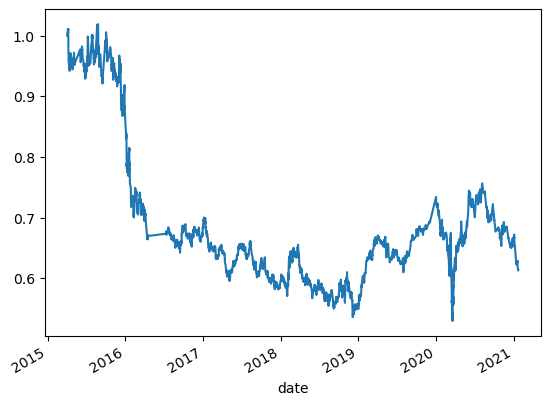

In [10]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [11]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [12]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

In [13]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [14]:
# Select the ending period for the training data with an offset of 3 months
offset_months = 3

training_end = X.index.min() + DateOffset(months=offset_months)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [16]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458
2015-07-06 14:30:00,23.6725,25.0206
2015-07-07 11:30:00,23.4800,24.9951


In [17]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Check the first few values of X_train_scaled and y_train to make sure they're the same later
display(X_train_scaled[:10])
display(y_train[:10])

array([[-0.41008202, -1.94104893],
       [-0.40662893, -1.91715849],
       [-0.39972274, -1.9039425 ],
       [-0.38936345, -1.89098066],
       [-0.36864488, -1.87776467],
       [-0.2857706 , -1.85666992],
       [-0.20980251, -1.83430439],
       [-0.13038132, -1.81092226],
       [-0.05096013, -1.78626935],
       [-0.04405394, -1.75754999]])

date
2015-04-02 15:00:00    1.0
2015-04-02 15:15:00    1.0
2015-04-02 15:30:00    1.0
2015-04-02 15:45:00    1.0
2015-04-06 09:30:00    1.0
2015-04-06 09:45:00    1.0
2015-04-06 10:15:00    1.0
2015-04-06 11:45:00    1.0
2015-04-06 12:00:00   -1.0
2015-04-06 13:30:00    1.0
Name: Signal, dtype: float64

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [19]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
pd.DataFrame(svm_pred).value_counts()

 1.0    3931
-1.0     161
Name: count, dtype: int64

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [21]:
# Generate a confusion matrix for the model
cm_baseline = confusion_matrix(y_test, svm_pred)

print(f"Confusion matrix for the trading algorithm:\n{offset_months}-month Training Window, {short_window}-period Fast SMA, {long_window}-period Slow SMA\n")
print(cm_baseline)

Confusion matrix for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA

[[  69 1735]
 [  92 2196]]


In [22]:
# Plot a confusion matrix using ConfusionMatrixDisplay
# cmd_baseline = ConfusionMatrixDisplay(cm_baseline, display_labels=['sell','buy'])
# cmd_baseline.plot(colorbar=False,cmap="binary")

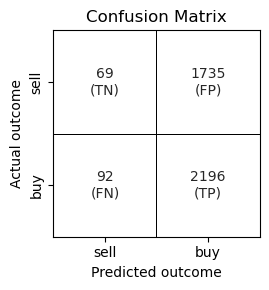

In [23]:
# Plot a confusion matrix using the helper function and save it
plot_confusion_matrix(cm_baseline, ['sell','buy'], title="Confusion Matrix", filename='01_baseline_trading_algorithm'
                     , labelplot=True
                     )

In [24]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(f"Classification report for the trading algorithm:\n{offset_months}-month Training Window, {short_window}-period Fast SMA, {long_window}-period Slow SMA\n\n")
print(svm_testing_report)


Classification report for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [25]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']

# Add the model returns to the DataFrame
predictions_df['Model Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()

# Drop the one NaN value that was created after the shift
predictions_df = predictions_df.dropna()

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns,Model Returns
date,,,,
2015-07-06 10:45:00,1.0,0.007237,-0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,0.018423,-0.018423
2015-07-07 13:45:00,1.0,0.005674,-0.005674,0.005674


,Predicted,Actual Returns,Strategy Returns,Model Returns
date,,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

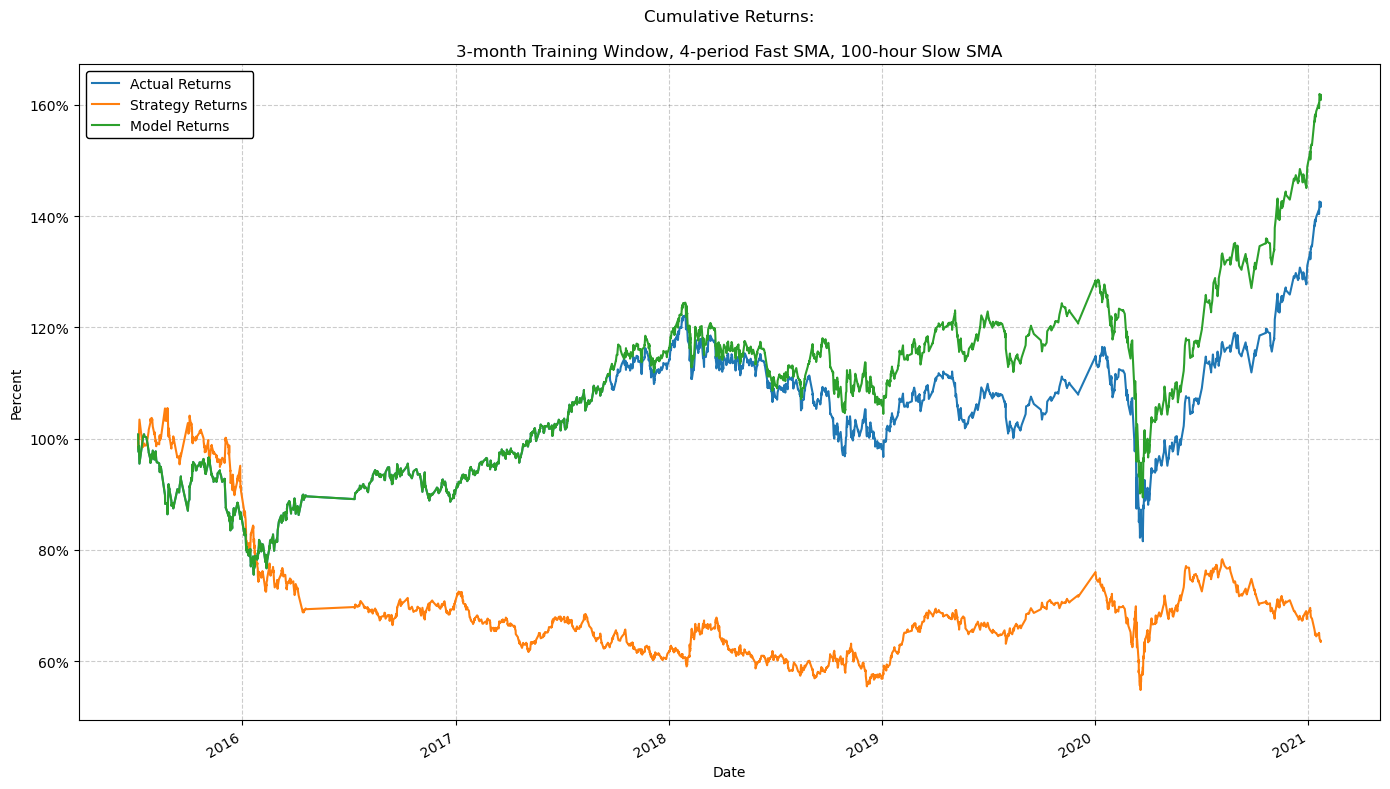

In [26]:
# Plot the actual returns versus the strategy returns

# Initialize the figure, including the size 
fig = (1 + predictions_df[['Actual Returns', 'Strategy Returns','Model Returns']]).cumprod().plot(
    figsize=(14,8)
)

# Add a title to the plot
plt.title(f"Cumulative Returns:\n\n{offset_months}-month Training Window, {short_window}-period Fast SMA, {long_window}-hour Slow SMA")

# Create a variable that refers to the axis
ax = plt.gca()

# Set the x- and y-axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Percent')

# Format the y-axis as a percentage
# The kwarg in PercentFormatter is the float value used as the divisor to create the percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Rescale the axis boundaries
# ax.axis([
#     min(signals_df.index) - (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Minimum value on the x-axis
#     max(signals_df.index) + (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Maximum value on the x-axis
#     0,
#     1.4
# ])

# Add a horizontal line to improve readability
# ax.axhline(y=1, color='k', linestyle="--", alpha=0.2)

# Create a light grid to improve readability
ax.grid(which='major', color='k', linestyle='--', alpha=0.2)

# Set the legend paramters
plt.legend(
    framealpha=1.0, # Make the legend opaque
    edgecolor='k' # Set the edge color to black
)

# Reduce the whitespace around the plot
plt.tight_layout()

# Save the figure as a PNG
plt.savefig(Path("./Plots/01_baseline_trading_algorithm_returns.png"))

plt.show()

---

### Creating Summary Dataframes

At the end of this notebook I'll make two summary plots, so I'm going to create two dataframes containing the strategy and model results.

In [27]:
# Create a dataframe to store all of the strategy results
strategy_results_df = predictions_df[['Actual Returns', 'Strategy Returns']].copy()

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Baseline Returns'}, inplace=True)

strategy_results_df.head()

,Actual Returns,Baseline Returns
date,,
2015-07-06 10:45:00,0.007237,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721
2015-07-06 14:30:00,-0.003841,0.003841
2015-07-07 11:30:00,-0.018423,0.018423
2015-07-07 13:45:00,0.005674,-0.005674


In [28]:
# Create a dataframe to store all of the model results
model_results_df = predictions_df[['Actual Returns', 'Model Returns']].copy()

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'Baseline Model Returns'}, inplace=True)

model_results_df.head()

,Actual Returns,Baseline Model Returns
date,,
2015-07-06 10:45:00,0.007237,0.007237
2015-07-06 14:15:00,-0.009721,-0.009721
2015-07-06 14:30:00,-0.003841,-0.003841
2015-07-07 11:30:00,-0.018423,-0.018423
2015-07-07 13:45:00,0.005674,0.005674


---

## Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### A Quick Note on the Approach

To tune the baseline trading algorithm, I'm going to make a python function of the process above, which will make checking other parameters much simpler and faster.  I'll also create a python function for making the plot.

### Helper Function 2: Making the Trading Algorithm

In [29]:
# Define a function for making the training algorithm

def trading_algorithm(ohlcv_df_arg, sma_short_window, sma_long_window, training_data_offset_months, confusion_matrix_filename):
    # Create the signals_df by filtering the date index and close columns from the ohlcv_df
    signals_df_local_var = ohlcv_df_arg.loc[:, ["close"]]
    
    # Use the pct_change function to generate returns from close prices
    signals_df_local_var["Actual Returns"] = signals_df_local_var["close"].pct_change()
    
    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Generate the fast and slow simple moving averages
    # Note that the data is in 15-minute increments, so every 4 values in succession is 1 hour
    signals_df_local_var['SMA_Fast'] = signals_df_local_var['close'].rolling(window=sma_short_window).mean()
    signals_df_local_var['SMA_Slow'] = signals_df_local_var['close'].rolling(window=sma_long_window).mean()

    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Initialize the new Signal column
    signals_df_local_var['Signal'] = 0.0
    
    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df_local_var.loc[(signals_df_local_var['Actual Returns'] >= 0), 'Signal'] = 1
    
    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df_local_var.loc[(signals_df_local_var['Actual Returns'] < 0), 'Signal'] = -1

    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df_local_var['Strategy Returns'] = signals_df_local_var['Actual Returns'] * signals_df_local_var['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X_local_var = signals_df_local_var[['SMA_Fast', 'SMA_Slow']].shift().dropna()
    
    # Create the target set selecting the Signal column and assiging it to y
    y_local_var = signals_df_local_var['Signal']
    
    # Select the start of the training period
    training_begin_local_var = X_local_var.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end_local_var = X_local_var.index.min() + DateOffset(months=training_data_offset_months)

    # Generate the X_train and y_train DataFrames
    X_train_local_var = X_local_var.loc[training_begin_local_var:training_end_local_var]
    y_train_local_var = y_local_var.loc[training_begin_local_var:training_end_local_var]

    # Generate the X_test and y_test DataFrames
    X_test_local_var = X_local_var.loc[training_end_local_var+DateOffset(hours=1):]
    y_test_local_var = y_local_var.loc[training_end_local_var+DateOffset(hours=1):]

    # Scale the features DataFrames
    # Create a StandardScaler instance
    scaler_local_var = StandardScaler()
    
    # Apply the scaler model to fit the X-train data
    X_scaler_local_var = scaler_local_var.fit(X_train_local_var)
    
    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled_local_var = X_scaler_local_var.transform(X_train_local_var)
    X_test_scaled_local_var = X_scaler_local_var.transform(X_test_local_var)
    
    # From SVM, instantiate SVC classifier model instance
    svm_model_local_var = svm.SVC()

    # Fit the model to the data using the training data
    svm_model_local_var = svm_model_local_var.fit(X_train_scaled_local_var, y_train_local_var)
    
    # Use the testing data to make the model predictions
    svm_pred_local_var = svm_model_local_var.predict(X_test_scaled_local_var)

    # Generate a confusion matrix for the model
    confusion_matrix_local_var = confusion_matrix(y_test_local_var, svm_pred_local_var)
    print(f"Confusion matrix for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n")
    # print(confusion_matrix_local_var)
    # Print some whitespace
    # print("\n")
    
    # Plot a confusion matrix using the helper function and save it
    plot_confusion_matrix(confusion_matrix_local_var, ['sell','buy'], title="Confusion Matrix", filename=confusion_matrix_filename
                     , labelplot=True
                     )
    # Print some whitespace
    print()
    
    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report_local_var = classification_report(y_test_local_var, svm_pred_local_var)
    
    # Print the classification report
    print(f"Classification report for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n\n")
    print(svm_testing_report_local_var)
    # Print some whitespace
    print()

    # Create a new empty predictions DataFrame:
    # Create a predictions DataFrame
    predictions_df_local_var = pd.DataFrame(index=X_test_local_var.index)
    
    # Add the SVM model predictions to the DataFrame
    predictions_df_local_var['Predicted'] = svm_pred_local_var
    
    # Add the actual returns to the DataFrame
    predictions_df_local_var['Actual Returns'] = signals_df_local_var['Actual Returns']
    
    # Add the strategy returns to the DataFrame
    predictions_df_local_var['Strategy Returns'] = signals_df_local_var['Strategy Returns']

    # Add the model returns to the DataFrame
    predictions_df_local_var['Model Returns'] = predictions_df_local_var['Actual Returns'] * predictions_df_local_var['Predicted'].shift()

    # Drop the one NaN value that was created after the shift
    predictions_df_local_var = predictions_df_local_var.dropna()

    return predictions_df_local_var

### Helper Function 3: Making the Plot

In [30]:
# Define a function for making the plot

def create_plot(predictions_df_arg, sma_short_window, sma_long_window, training_data_offset_months, plot_filename, plot_title_text="Cumulative Returns:\n\n"):
    # Plot the actual returns versus the strategy returns
    
    # Initialize the figure, including the size
    fig = (1 + predictions_df_arg[['Actual Returns', 'Strategy Returns', 'Model Returns']]).cumprod().plot(
    # fig = (1 + predictions_df_arg[['Actual Returns', 'Strategy Returns']]).cumprod().plot(
        figsize=(14,8)
    )
    
    # Add a title to the plot
    plt.title(f"{plot_title_text}{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA")
    
    # Create a variable that refers to the axis
    ax = plt.gca()
    
    # Set the x- and y-axis labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent')
    
    # Format the y-axis as a percentage
    # The kwarg in PercentFormatter is the float value used as the divisor to create the percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Rescale the axis boundaries
    # ax.axis([
    #     min(signals_df.index) - (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Minimum value on the x-axis
    #     max(signals_df.index) + (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Maximum value on the x-axis
    #     0,
    #     1.4
    # ])
    
    # Add a horizontal line to improve readability
    # ax.axhline(y=1, color='k', linestyle="--", alpha=0.2)
    
    # Create a light grid to improve readability
    ax.grid(which='major', color='k', linestyle='--', alpha=0.2)
    
    # Set the legend paramters
    plt.legend(
        framealpha=1.0, # Make the legend opaque
        edgecolor='k' # Set the edge color to black
    )

    # Reduce the whitespace around the plot
    plt.tight_layout()
    
    # Save the figure as a PNG
    relative_file_path = "./Plots/" + str(plot_filename) + ".png"
    plt.savefig(Path(relative_file_path))
    
    return plt.show()

## Case 2: New Training Windows

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

Confusion matrix for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA



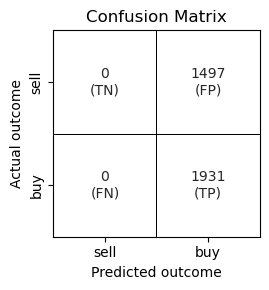


Classification report for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1497
         1.0       0.56      1.00      0.72      1931

    accuracy                           0.56      3428
   macro avg       0.28      0.50      0.36      3428
weighted avg       0.32      0.56      0.41      3428




In [31]:
# Set the initial variables
sma_short_window = 4
sma_long_window = 100
training_data_offset_months = 12
file_name = "02_new_training_window"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_tuned_algorithm_1 = trading_algorithm(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

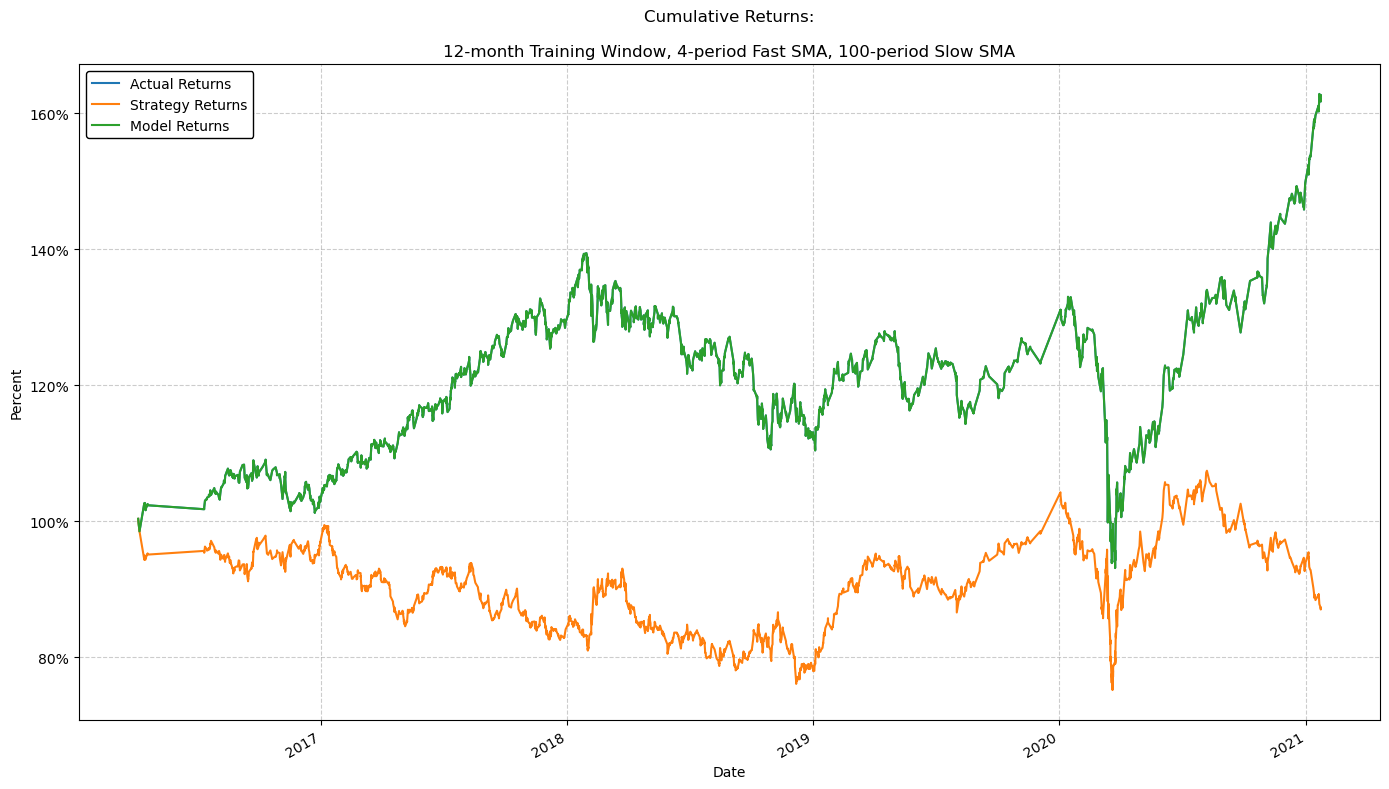

In [32]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_tuned_algorithm_1, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [33]:
predictions_df_tuned_algorithm_1.head()

,Predicted,Actual Returns,Strategy Returns,Model Returns
date,,,,
2016-04-04 13:00:00,1.0,0.003354,0.003354,0.003354
2016-04-06 12:15:00,1.0,-0.018363,-0.018363,-0.018363
2016-04-13 15:00:00,1.0,0.041955,-0.041955,0.041955
2016-04-13 15:45:00,1.0,-0.000474,-0.000474,-0.000474
2016-04-14 09:45:00,1.0,-0.006161,0.006161,-0.006161


In [34]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_tuned_algorithm_1[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'New Training Window'}, inplace=True)

In [35]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[results_df['New Training Window'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window
date,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN
2015-07-06 14:30:00,-0.003841,0.003841,NaN
2015-07-07 11:30:00,-0.018423,0.018423,NaN
2015-07-07 13:45:00,0.005674,-0.005674,NaN


In [36]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_tuned_algorithm_1[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'New Training Window Model'}, inplace=True)

In [37]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['New Training Window'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model
date,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN
2015-07-06 14:30:00,-0.003841,-0.003841,NaN
2015-07-07 11:30:00,-0.018423,-0.018423,NaN
2015-07-07 13:45:00,0.005674,0.005674,NaN


## Case 3: New SMA Windows

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

Confusion matrix for the trading algorithm:
3-month Training Window, 8-period Fast SMA, 80-period Slow SMA



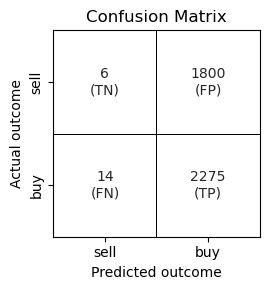


Classification report for the trading algorithm:
3-month Training Window, 8-period Fast SMA, 80-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.30      0.00      0.01      1806
         1.0       0.56      0.99      0.71      2289

    accuracy                           0.56      4095
   macro avg       0.43      0.50      0.36      4095
weighted avg       0.44      0.56      0.40      4095




In [38]:
# Set the initial variables
sma_short_window = 8
sma_long_window = 80
training_data_offset_months = 3
file_name = "03_new_sma_windows"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_tuned_algorithm_2 = trading_algorithm(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

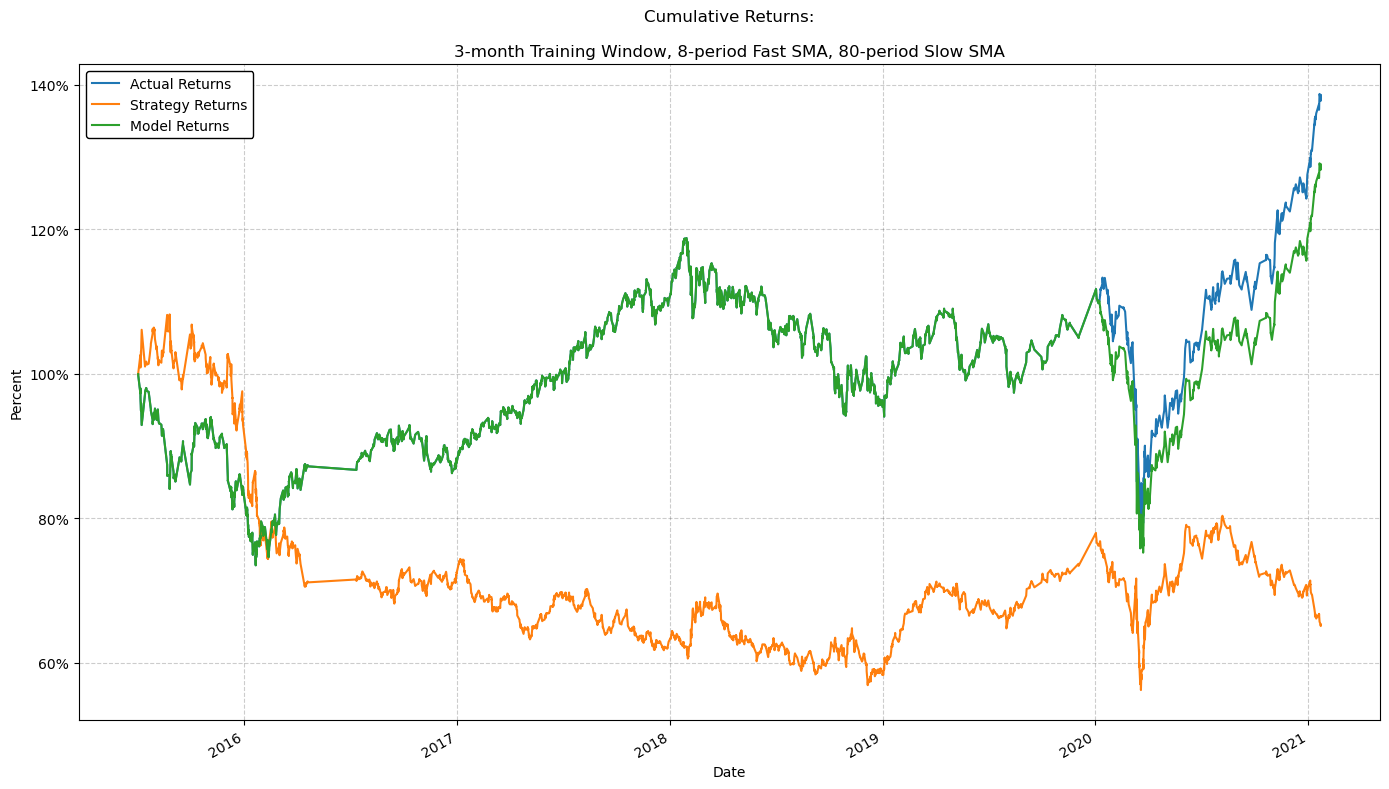

In [39]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_tuned_algorithm_2, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [40]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_tuned_algorithm_2[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'New SMA Windows'}, inplace=True)

In [41]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['New Training Window'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows
date,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674


In [42]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_tuned_algorithm_2[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'New SMA Windows Model'}, inplace=True)

In [43]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['New SMA Windows Model'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model
date,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674


### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Analysis Revisited: Establish a Baseline Performance

As noted in the `README.md` file, the Signal column in the dataframe (which is the target variable for prediction) doesn't actually depend on the simple moving average (SMA) windows.  The Signal column is just tracking whether or not the Actual Returns column is positive or negative.  As a result, changing the training or SMA windows shouldn't affect performance very much, and the above plots illustrate it.

Consequently, I'm going to redo the above anaylsis with a simple, but more appropriate approach, changing the Signals column to be `1` when the short SMA is greater than the long SMA and `-1` when the short SMA is less than the long SMA.

### Helper Function 4: Making a Revised Trading Algorithm

In [44]:
# Define a function for making the new training algorithm

def trading_algorithm_revisited(ohlcv_df_arg, sma_short_window, sma_long_window, training_data_offset_months, confusion_matrix_filename):
    # Create the signals_df by filtering the date index and close columns from the ohlcv_df
    signals_df_local_var = ohlcv_df_arg.loc[:, ["close"]]
    
    # Use the pct_change function to generate returns from close prices
    signals_df_local_var["Actual Returns"] = signals_df_local_var["close"].pct_change()
    
    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Generate the fast and slow simple moving averages
    # Note that the data is in 15-minute increments, so every 4 values in succession is 1 hour
    signals_df_local_var['SMA_Fast'] = signals_df_local_var['close'].rolling(window=sma_short_window).mean()
    signals_df_local_var['SMA_Slow'] = signals_df_local_var['close'].rolling(window=sma_long_window).mean()

    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Initialize the new Signal column
    signals_df_local_var['Signal'] = 0.0
    
    # When SMA_Fast is greater than or equal to SMA_Slow, generate signal to buy stock long
    signals_df_local_var.loc[(signals_df_local_var['SMA_Fast'] >= signals_df_local_var['SMA_Slow']), 'Signal'] = 1
    
    # When SMA_Fast is less than SMA_Slow, generate signal to sell stock short
    signals_df_local_var.loc[(signals_df_local_var['SMA_Fast'] < signals_df_local_var['SMA_Slow']), 'Signal'] = -1

    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df_local_var['Strategy Returns'] = signals_df_local_var['Actual Returns'] * signals_df_local_var['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X_local_var = signals_df_local_var[['SMA_Fast', 'SMA_Slow']].shift().dropna()
    
    # Create the target set selecting the Signal column and assiging it to y
    y_local_var = signals_df_local_var['Signal']
    
    # Select the start of the training period
    training_begin_local_var = X_local_var.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end_local_var = X_local_var.index.min() + DateOffset(months=training_data_offset_months)

    # Generate the X_train and y_train DataFrames
    X_train_local_var = X_local_var.loc[training_begin_local_var:training_end_local_var]
    y_train_local_var = y_local_var.loc[training_begin_local_var:training_end_local_var]

    # Generate the X_test and y_test DataFrames
    X_test_local_var = X_local_var.loc[training_end_local_var+DateOffset(hours=1):]
    y_test_local_var = y_local_var.loc[training_end_local_var+DateOffset(hours=1):]

    # Scale the features DataFrames
    # Create a StandardScaler instance
    scaler_local_var = StandardScaler()
    
    # Apply the scaler model to fit the X-train data
    X_scaler_local_var = scaler_local_var.fit(X_train_local_var)
    
    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled_local_var = X_scaler_local_var.transform(X_train_local_var)
    X_test_scaled_local_var = X_scaler_local_var.transform(X_test_local_var)
    
    # From SVM, instantiate SVC classifier model instance
    svm_model_local_var = svm.SVC()

    # Fit the model to the data using the training data
    svm_model_local_var = svm_model_local_var.fit(X_train_scaled_local_var, y_train_local_var)
    
    # Use the testing data to make the model predictions
    svm_pred_local_var = svm_model_local_var.predict(X_test_scaled_local_var)

    # Generate a confusion matrix for the model
    confusion_matrix_local_var = confusion_matrix(y_test_local_var, svm_pred_local_var)
    print(f"Confusion matrix for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n")
    # print(confusion_matrix_local_var)
    # Print some whitespace
    # print("\n")
    
    # Plot a confusion matrix using the helper function and save it
    plot_confusion_matrix(confusion_matrix_local_var, ['sell','buy'], title="Confusion Matrix", filename=confusion_matrix_filename
                     , labelplot=True
                     )
    # Print some whitespace
    print()
    
    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report_local_var = classification_report(y_test_local_var, svm_pred_local_var)
    
    # Print the classification report
    print(f"Classification report for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n\n")
    print(svm_testing_report_local_var)
    # Print some whitespace
    print()

    # Create a new empty predictions DataFrame:
    # Create a predictions DataFrame
    predictions_df_local_var = pd.DataFrame(index=X_test_local_var.index)
    
    # Add the SVM model predictions to the DataFrame
    predictions_df_local_var['Predicted'] = svm_pred_local_var
    
    # Add the actual returns to the DataFrame
    predictions_df_local_var['Actual Returns'] = signals_df_local_var['Actual Returns']
    
    # Add the strategy returns to the DataFrame
    predictions_df_local_var['Strategy Returns'] = signals_df_local_var['Strategy Returns']

    # Add the model returns to the DataFrame
    predictions_df_local_var['Model Returns'] = predictions_df_local_var['Actual Returns'] * predictions_df_local_var['Predicted'].shift()
    
    # Drop the one NaN value that was created after the shift
    predictions_df_local_var = predictions_df_local_var.dropna()

    return predictions_df_local_var

## Case 4: Baseline Performance With New Trading Signals

Confusion matrix for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA



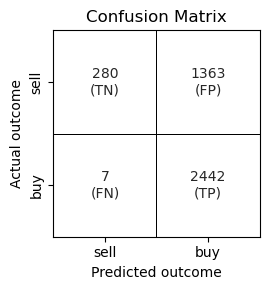


Classification report for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.98      0.17      0.29      1643
         1.0       0.64      1.00      0.78      2449

    accuracy                           0.67      4092
   macro avg       0.81      0.58      0.54      4092
weighted avg       0.78      0.67      0.58      4092




In [45]:
# Set the initial variables
sma_short_window = 4
sma_long_window = 100
training_data_offset_months = 3
file_name = "04_baseline_trading_algorithm_returns_revisited"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_baseline = trading_algorithm_revisited(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

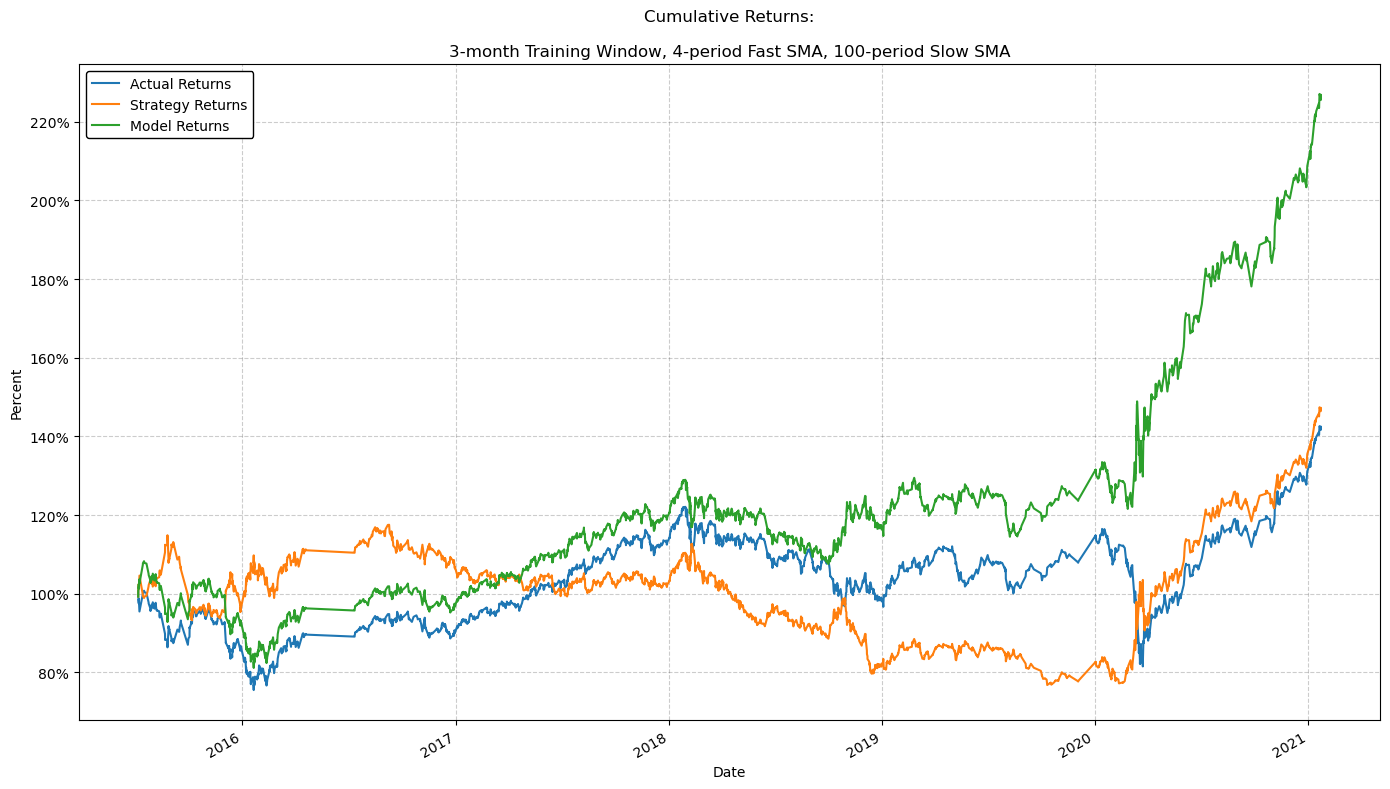

In [46]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_revisited_baseline, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [47]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_baseline[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Baseline Returns Revisited'}, inplace=True)

In [48]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['Baseline Returns Revisited'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited
date,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674


In [49]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_baseline[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'Baseline Returns Revisited Model'}, inplace=True)

In [50]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['Baseline Returns Revisited Model'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model
date,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674


## Case 5: Algorithm with New Trading Signals and a New Training Window

Confusion matrix for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA



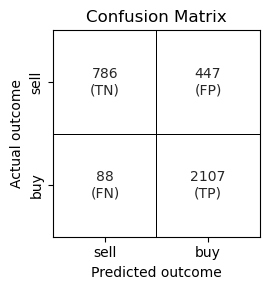


Classification report for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.90      0.64      0.75      1233
         1.0       0.82      0.96      0.89      2195

    accuracy                           0.84      3428
   macro avg       0.86      0.80      0.82      3428
weighted avg       0.85      0.84      0.84      3428




In [51]:
# Set the initial variables
sma_short_window = 4
sma_long_window = 100
training_data_offset_months = 12
file_name = "05_new_training_window_revisited"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_tuned_algorithm_1 = trading_algorithm_revisited(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

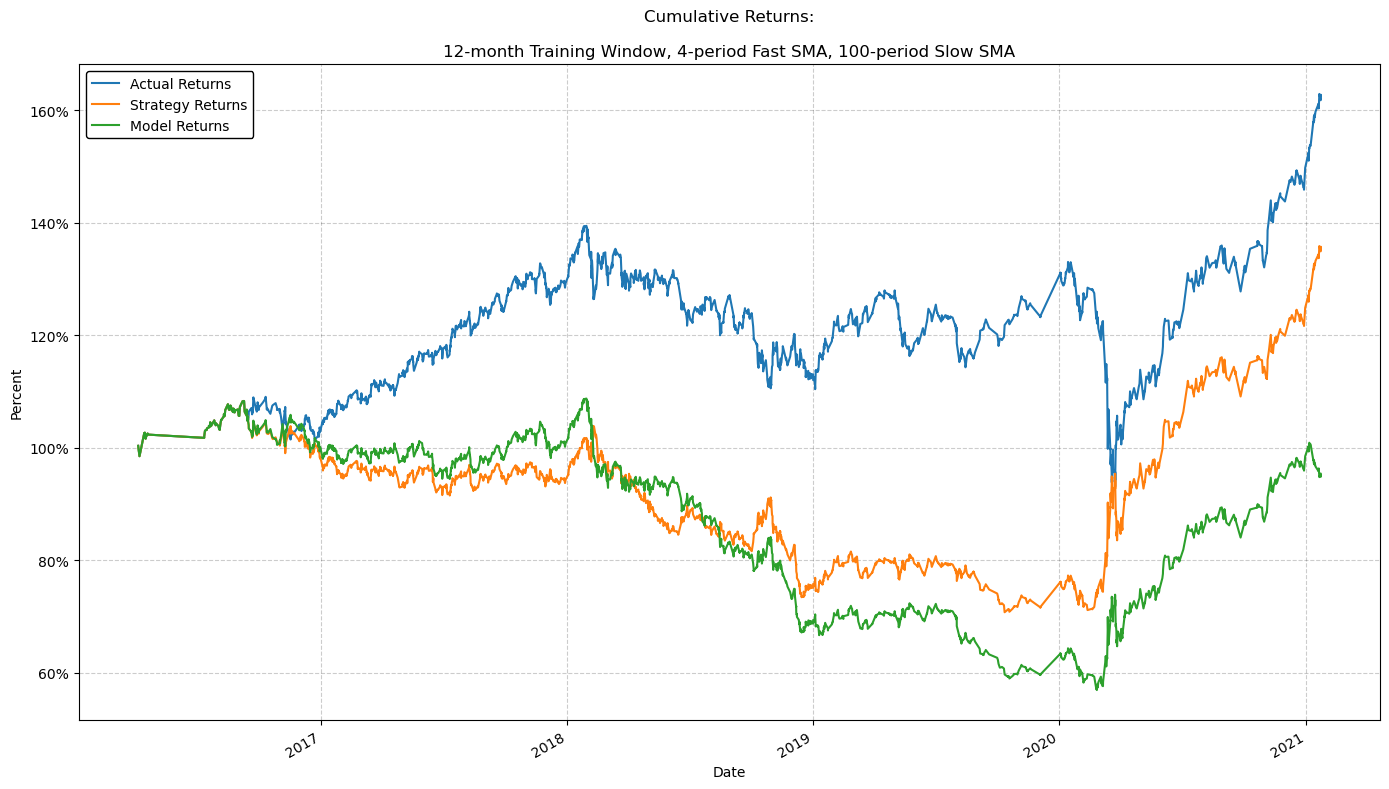

In [52]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_revisited_tuned_algorithm_1, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [53]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_tuned_algorithm_1[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'New Training Window Revisited'}, inplace=True)

In [54]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['New Training Window Revisited'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited
date,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN


In [55]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_tuned_algorithm_1[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'New Training Window Revisited Model'}, inplace=True)

In [56]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['New Training Window Revisited Model'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model
date,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN


## Case 6: Algorithm with New Trading Signals and New SMA Windows

Confusion matrix for the trading algorithm:
3-month Training Window, 8-period Fast SMA, 80-period Slow SMA



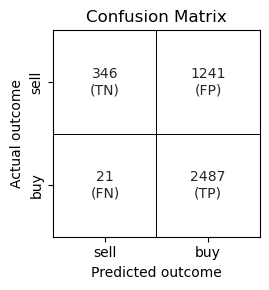


Classification report for the trading algorithm:
3-month Training Window, 8-period Fast SMA, 80-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.94      0.22      0.35      1587
         1.0       0.67      0.99      0.80      2508

    accuracy                           0.69      4095
   macro avg       0.80      0.60      0.58      4095
weighted avg       0.77      0.69      0.63      4095




In [57]:
# Set the initial variables
sma_short_window = 8
sma_long_window = 80
training_data_offset_months = 3
file_name = "06_new_sma_windows_revisited"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_tuned_algorithm_2 = trading_algorithm_revisited(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

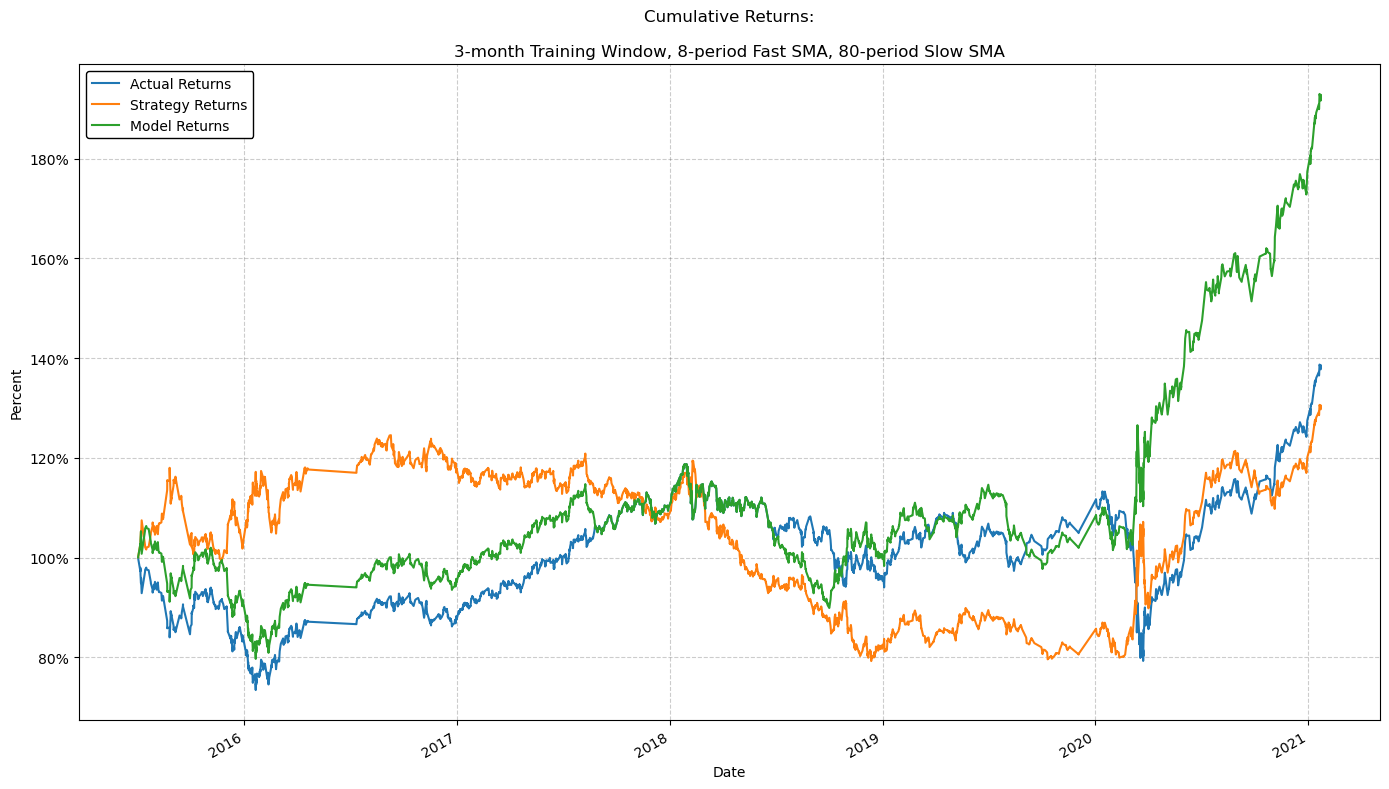

In [58]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_revisited_tuned_algorithm_2, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [59]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_tuned_algorithm_2[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'New SMA Windows Revisited'}, inplace=True)

In [60]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['New SMA Windows Revisited'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited
date,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674


In [61]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_tuned_algorithm_2[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'New SMA Windows Revisited Model'}, inplace=True)

In [62]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['New SMA Windows Revisited Model'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model
date,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674


## Case 7: Improving the Trading Strategy

Confusion matrix for the trading algorithm:
3-month Training Window, 32-period Fast SMA, 160-period Slow SMA



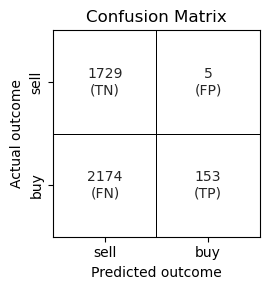


Classification report for the trading algorithm:
3-month Training Window, 32-period Fast SMA, 160-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61      1734
         1.0       0.97      0.07      0.12      2327

    accuracy                           0.46      4061
   macro avg       0.71      0.53      0.37      4061
weighted avg       0.74      0.46      0.33      4061




In [63]:
# Set the initial variables
sma_short_window = 32
sma_long_window = 160
training_data_offset_months = 3
file_name = "07_improved_trading_strategy"

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_tuned_algorithm_3 = trading_algorithm_revisited(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name)

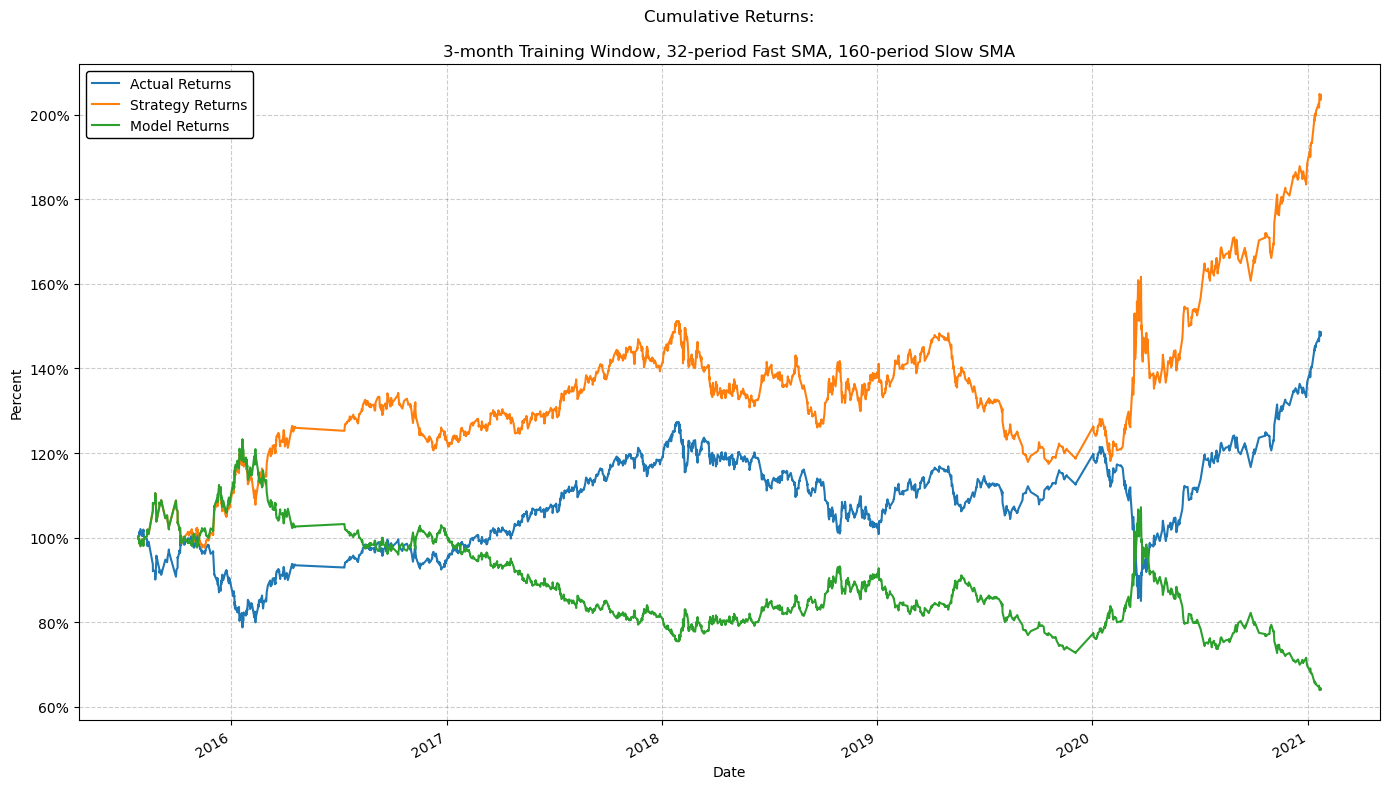

In [64]:
# Create the plot of trading algorithm performance
create_plot(predictions_df_revisited_tuned_algorithm_3, sma_short_window, sma_long_window, training_data_offset_months, file_name)

In [65]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_tuned_algorithm_3[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Improved Trading Strategy'}, inplace=True)

In [66]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['Improved Trading Strategy'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited,Improved Trading Strategy
date,,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841,NaN
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423,NaN
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674,NaN


In [67]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_tuned_algorithm_3[['Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'Model Returns':'Improved Trading Strategy Model'}, inplace=True)

In [68]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['Improved Trading Strategy Model'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model,Improved Trading Strategy Model
date,,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841,NaN
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423,NaN
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674,NaN


---

## Case 8: Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Helper Function 5: Making the LR Plots, Adding SVC Plots as a Point of Comparison

In [69]:
# Define a function for making the plot

def create_lr_plot(predictions_df_arg, sma_short_window, sma_long_window, training_data_offset_months, plot_filename, plot_title_text="Cumulative Returns:\n\n"):
    # Plot the actual returns versus the strategy returns
    
    # Initialize the figure, including the size
    fig = (1 + predictions_df_arg[['Actual Returns', 'Strategy Returns', 'SVC Model Returns', 'LR Model Returns']]).cumprod().plot(
    # fig = (1 + predictions_df_arg[['Actual Returns', 'Strategy Returns']]).cumprod().plot(
        figsize=(14,8)
    )
    
    # Add a title to the plot
    plt.title(f"{plot_title_text}{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA")
    
    # Create a variable that refers to the axis
    ax = plt.gca()
    
    # Set the x- and y-axis labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent')
    
    # Format the y-axis as a percentage
    # The kwarg in PercentFormatter is the float value used as the divisor to create the percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # ax.lines[3].set_alpha(0.5) 
    
    # Rescale the axis boundaries
    # ax.axis([
    #     min(signals_df.index) - (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Minimum value on the x-axis
    #     max(signals_df.index) + (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Maximum value on the x-axis
    #     0,
    #     1.4
    # ])
    
    # Add a horizontal line to improve readability
    # ax.axhline(y=1, color='k', linestyle="--", alpha=0.2)
    
    # Create a light grid to improve readability
    ax.grid(which='major', color='k', linestyle='--', alpha=0.2)
    
    # Set the legend paramters
    plt.legend(
        framealpha=1.0, # Make the legend opaque
        edgecolor='k' # Set the edge color to black
    )

    # Reduce the whitespace around the plot
    plt.tight_layout()
    
    # Save the figure as a PNG
    relative_file_path = "./Plots/" + str(plot_filename) + ".png"
    plt.savefig(Path(relative_file_path))
    
    return plt.show()

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [70]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model_instance = LogisticRegression()


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [71]:
# Check that X_train_scaled and y_train haven't changed since the baseline case
display(X_train_scaled[:10])
display(y_train[:10])

array([[-0.41008202, -1.94104893],
       [-0.40662893, -1.91715849],
       [-0.39972274, -1.9039425 ],
       [-0.38936345, -1.89098066],
       [-0.36864488, -1.87776467],
       [-0.2857706 , -1.85666992],
       [-0.20980251, -1.83430439],
       [-0.13038132, -1.81092226],
       [-0.05096013, -1.78626935],
       [-0.04405394, -1.75754999]])

date
2015-04-02 15:00:00    1.0
2015-04-02 15:15:00    1.0
2015-04-02 15:30:00    1.0
2015-04-02 15:45:00    1.0
2015-04-06 09:30:00    1.0
2015-04-06 09:45:00    1.0
2015-04-06 10:15:00    1.0
2015-04-06 11:45:00    1.0
2015-04-06 12:00:00   -1.0
2015-04-06 13:30:00    1.0
Name: Signal, dtype: float64

In [72]:
# Fit the model using the training data
logistic_regression_model = logistic_regression_model_instance.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
lr_signal_predictions = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
lr_signal_predictions

array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

Confusion matrix for the logistic regression model:



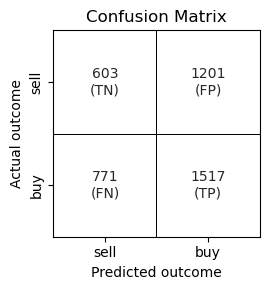

In [73]:
# Generate a confusion matrix for the model
confusion_matrix_logistic_regression_model = confusion_matrix(y_test, lr_signal_predictions)
print(f"Confusion matrix for the logistic regression model:\n")

# Plot a confusion matrix using the helper function and save it
plot_confusion_matrix(confusion_matrix_logistic_regression_model, ['sell','buy'], title="Confusion Matrix", filename="08_logistic_regression_baseline"
    , labelplot=True
)

In [74]:
# Use a classification report to evaluate the model using the predictions and testing data
logistic_regression_classification_report = classification_report(y_test, lr_signal_predictions)

# Print the classification report
print(f"Classification report for the logistic regression model:\n\n")
print(logistic_regression_classification_report)

Classification report for the logistic regression model:


              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



In [75]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df_logistic_regression = pd.DataFrame(index=X_test.index)

# Add the logistic regression model predictions to the DataFrame
predictions_df_logistic_regression['Predicted'] = lr_signal_predictions

# Add the actual returns to the DataFrame
predictions_df_logistic_regression['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df_logistic_regression['Strategy Returns'] = signals_df['Strategy Returns']

# Add the LR model returns to the DataFrame
predictions_df_logistic_regression['LR Model Returns'] = predictions_df_logistic_regression['Actual Returns'] * predictions_df_logistic_regression['Predicted'].shift()

# Add the SVC model returns to the Dataframe
predictions_df_logistic_regression['SVC Model Returns'] = model_results_df['Baseline Model Returns']

# Drop the one NaN value that was created after the shift
predictions_df_logistic_regression = predictions_df_logistic_regression.dropna()

# Review the DataFrame
display(predictions_df_logistic_regression.head())
display(predictions_df_logistic_regression.tail())

,Predicted,Actual Returns,Strategy Returns,LR Model Returns,SVC Model Returns
date,,,,,
2015-07-06 10:45:00,1.0,0.007237,-0.007237,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,0.003841,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,0.018423,-0.018423,-0.018423
2015-07-07 13:45:00,1.0,0.005674,-0.005674,0.005674,0.005674


,Predicted,Actual Returns,Strategy Returns,LR Model Returns,SVC Model Returns
date,,,,,
2021-01-22 09:30:00,-1.0,-0.006866,-0.006866,0.006866,-0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405,-0.002405,0.002405
2021-01-22 13:45:00,-1.0,0.002099,0.002099,-0.002099,0.002099
2021-01-22 14:30:00,-1.0,0.001496,0.001496,-0.001496,0.001496
2021-01-22 15:45:00,-1.0,-0.000896,-0.000896,0.000896,-0.000896


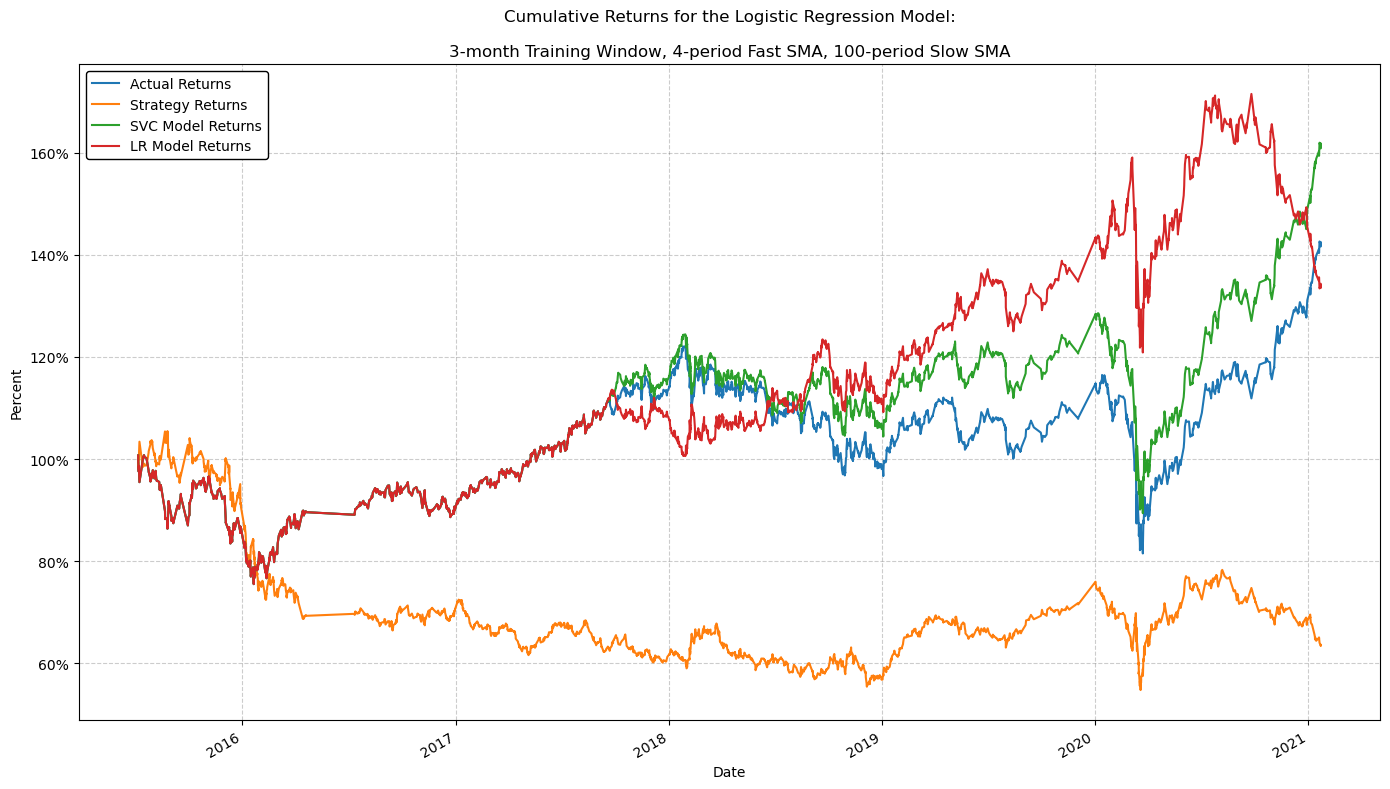

In [76]:
create_lr_plot(predictions_df_logistic_regression, short_window, long_window, offset_months, '08_logistic_regression_baseline_returns', "Cumulative Returns for the Logistic Regression Model:\n\n")

In [77]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_logistic_regression[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Baseline Returns LR'}, inplace=True)

In [78]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[results_df['New Training Window'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited,Improved Trading Strategy,Baseline Returns LR
date,,,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237,NaN,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841,NaN,0.003841
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423,NaN,0.018423
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674,NaN,-0.005674


In [79]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_logistic_regression[['LR Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'LR Model Returns':'Baseline Returns Model LR'}, inplace=True)

In [80]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['New Training Window'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model,Improved Trading Strategy Model,Baseline Returns Model LR
date,,,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237,NaN,0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841,NaN,-0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423,NaN,-0.018423
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674,NaN,0.005674


## New Machine Learning Classifier Using the New Trading Signals

### Helper Function 6: Making a Revised Trading Algorithm with the New Signals

In [81]:
# Define a function for making the new training algorithm

def trading_algorithm_revisited_new_classifier(ohlcv_df_arg, sma_short_window, sma_long_window, training_data_offset_months, confusion_matrix_filename, svc_model_column):
    # Create the signals_df by filtering the date index and close columns from the ohlcv_df
    signals_df_local_var = ohlcv_df_arg.loc[:, ["close"]]
    
    # Use the pct_change function to generate returns from close prices
    signals_df_local_var["Actual Returns"] = signals_df_local_var["close"].pct_change()
    
    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Generate the fast and slow simple moving averages
    # Note that the data is in 15-minute increments, so every 4 values in succession is 1 hour
    signals_df_local_var['SMA_Fast'] = signals_df_local_var['close'].rolling(window=sma_short_window).mean()
    signals_df_local_var['SMA_Slow'] = signals_df_local_var['close'].rolling(window=sma_long_window).mean()

    # Drop all NaN values from the DataFrame
    signals_df_local_var = signals_df_local_var.dropna()
    
    # Initialize the new Signal column
    signals_df_local_var['Signal'] = 0.0
    
    # When SMA_Fast is greater than or equal to SMA_Slow, generate signal to buy stock long
    signals_df_local_var.loc[(signals_df_local_var['SMA_Fast'] >= signals_df_local_var['SMA_Slow']), 'Signal'] = 1
    
    # When SMA_Fast is less than SMA_Slow, generate signal to sell stock short
    signals_df_local_var.loc[(signals_df_local_var['SMA_Fast'] < signals_df_local_var['SMA_Slow']), 'Signal'] = -1

    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df_local_var['Strategy Returns'] = signals_df_local_var['Actual Returns'] * signals_df_local_var['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X_local_var = signals_df_local_var[['SMA_Fast', 'SMA_Slow']].shift().dropna()
    
    # Create the target set selecting the Signal column and assiging it to y
    y_local_var = signals_df_local_var['Signal']
    
    # Select the start of the training period
    training_begin_local_var = X_local_var.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end_local_var = X_local_var.index.min() + DateOffset(months=training_data_offset_months)

    # Generate the X_train and y_train DataFrames
    X_train_local_var = X_local_var.loc[training_begin_local_var:training_end_local_var]
    y_train_local_var = y_local_var.loc[training_begin_local_var:training_end_local_var]

    # Generate the X_test and y_test DataFrames
    X_test_local_var = X_local_var.loc[training_end_local_var+DateOffset(hours=1):]
    y_test_local_var = y_local_var.loc[training_end_local_var+DateOffset(hours=1):]

    # Scale the features DataFrames
    # Create a StandardScaler instance
    scaler_local_var = StandardScaler()
    
    # Apply the scaler model to fit the X-train data
    X_scaler_local_var = scaler_local_var.fit(X_train_local_var)
    
    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled_local_var = X_scaler_local_var.transform(X_train_local_var)
    X_test_scaled_local_var = X_scaler_local_var.transform(X_test_local_var)

    # Initiate the model instance
    logistic_regression_model_instance_local_var = LogisticRegression()
    
    # Fit the model using the training data
    logistic_regression_model_local_var = logistic_regression_model_instance_local_var.fit(X_train_scaled_local_var, y_train_local_var)
    
    # Use the testing dataset to generate the predictions for the new model
    lr_signal_predictions_local_var = logistic_regression_model_local_var.predict(X_test_scaled_local_var)

    # Generate a confusion matrix for the model
    confusion_matrix_local_var = confusion_matrix(y_test_local_var, lr_signal_predictions_local_var)
    print(f"Confusion matrix for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n")
    # print(confusion_matrix_local_var)
    # Print some whitespace
    # print("\n")
    
    # Plot a confusion matrix using the helper function and save it
    plot_confusion_matrix(confusion_matrix_local_var, ['sell','buy'], title="Confusion Matrix", filename=confusion_matrix_filename
                     , labelplot=True
                     )
    # Print some whitespace
    print()
    
    # Use a classification report to evaluate the model using the predictions and testing data
    logistic_regression_classification_report_local_var = classification_report(y_test_local_var, lr_signal_predictions_local_var)
    
    # Print the classification report
    print(f"Classification report for the trading algorithm:\n{training_data_offset_months}-month Training Window, {sma_short_window}-period Fast SMA, {sma_long_window}-period Slow SMA\n\n")
    print(logistic_regression_classification_report_local_var)
    # Print some whitespace
    print()

    # Create a new empty predictions DataFrame:
    # Create a predictions DataFrame
    predictions_df_local_var = pd.DataFrame(index=X_test_local_var.index)
    
    # Add the SVM model predictions to the DataFrame
    predictions_df_local_var['Predicted'] = lr_signal_predictions_local_var
    
    # Add the actual returns to the DataFrame
    predictions_df_local_var['Actual Returns'] = signals_df_local_var['Actual Returns']
    
    # Add the strategy returns to the DataFrame
    predictions_df_local_var['Strategy Returns'] = signals_df_local_var['Strategy Returns']

    # Add the model returns to the DataFrame
    predictions_df_local_var['LR Model Returns'] = predictions_df_local_var['Actual Returns'] * predictions_df_local_var['Predicted'].shift()

    # Add the SVC model returns to the Dataframe
    predictions_df_local_var['SVC Model Returns'] = svc_model_column
    
    # Drop the one NaN value that was created after the shift
    predictions_df_local_var = predictions_df_local_var.dropna()

    return predictions_df_local_var

## Case 9: Baseline Trading Algorithm with New Trading Signals and LR Classifiers

Confusion matrix for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA



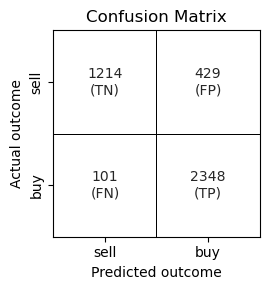


Classification report for the trading algorithm:
3-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.92      0.74      0.82      1643
         1.0       0.85      0.96      0.90      2449

    accuracy                           0.87      4092
   macro avg       0.88      0.85      0.86      4092
weighted avg       0.88      0.87      0.87      4092




In [82]:
# Set the initial variables
sma_short_window = 4
sma_long_window = 100
training_data_offset_months = 3
file_name = "09_baseline_trading_algorithm_revisited_logistic_regression"
svc_model_column = model_results_df['Baseline Returns Revisited Model']

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_logistic_regression_1 = trading_algorithm_revisited_new_classifier(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name, svc_model_column)

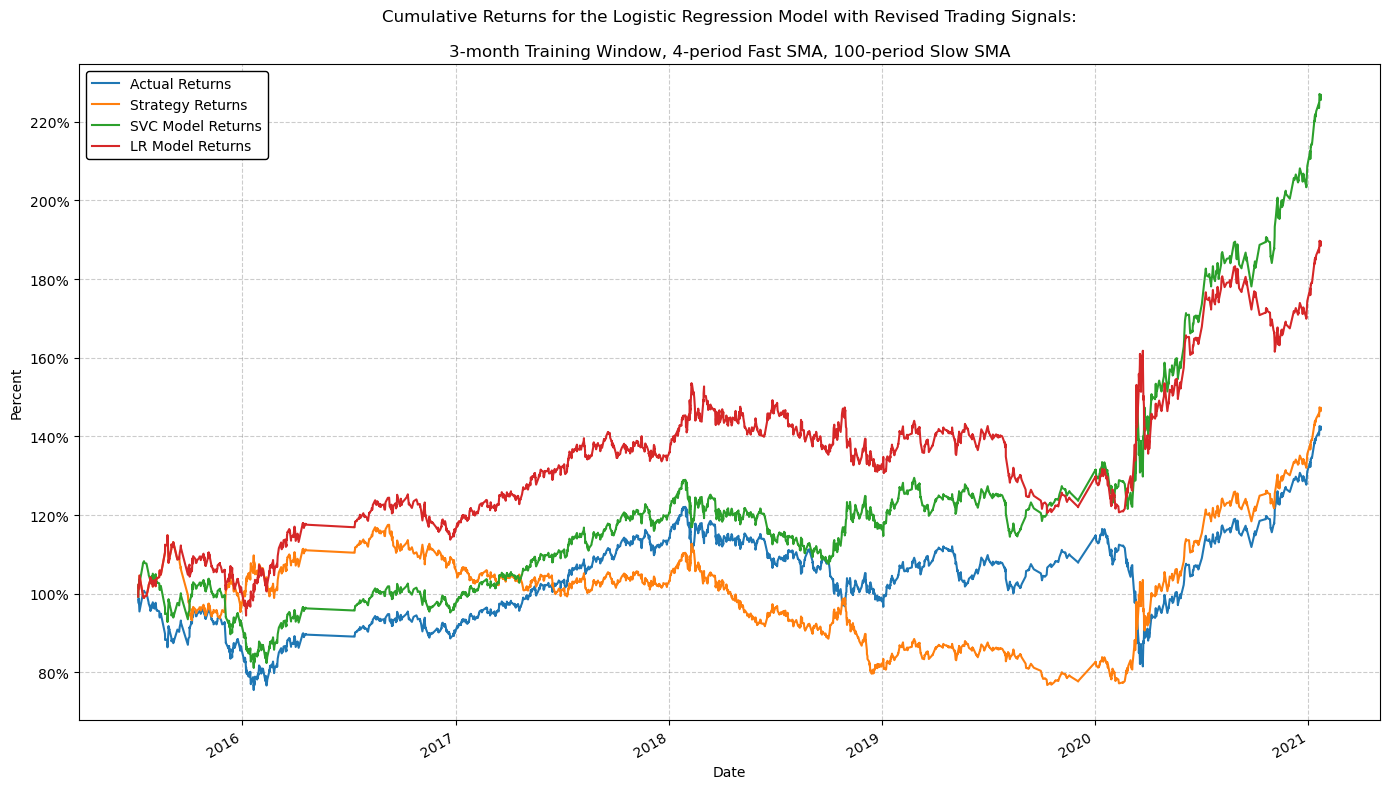

In [83]:
# Create the plot of trading algorithm performance
create_lr_plot(
    predictions_df_revisited_logistic_regression_1,
    sma_short_window,
    sma_long_window,
    training_data_offset_months,
    file_name
    , "Cumulative Returns for the Logistic Regression Model with Revised Trading Signals:\n\n"
)

In [84]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_logistic_regression_1[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Baseline Returns Revisited LR'}, inplace=True)

In [85]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['Baseline Returns Revisited LR'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited,Improved Trading Strategy,Baseline Returns LR,Baseline Returns Revisited LR
date,,,,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237,NaN,-0.007237,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841,NaN,0.003841,0.003841
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423,NaN,0.018423,0.018423
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674,NaN,-0.005674,-0.005674


In [86]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_logistic_regression_1[['LR Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'LR Model Returns':'Baseline Returns Revisited Model LR'}, inplace=True)

In [87]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['Baseline Returns Revisited Model LR'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model,Improved Trading Strategy Model,Baseline Returns Model LR,Baseline Returns Revisited Model LR
date,,,,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237,NaN,0.007237,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841,NaN,-0.003841,0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423,NaN,-0.018423,0.018423
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674,NaN,0.005674,-0.005674


## Case 10: Algorithm with New Trading Signals, a New Training Window, and LR Classifiers

Confusion matrix for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA



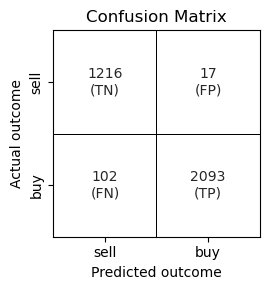


Classification report for the trading algorithm:
12-month Training Window, 4-period Fast SMA, 100-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.92      0.99      0.95      1233
         1.0       0.99      0.95      0.97      2195

    accuracy                           0.97      3428
   macro avg       0.96      0.97      0.96      3428
weighted avg       0.97      0.97      0.97      3428




In [88]:
# Set the initial variables
sma_short_window = 4
sma_long_window = 100
training_data_offset_months = 12
file_name = "10_new_training_window_revisited_logistic_regression"
svc_model_column = model_results_df['New Training Window Revisited Model']

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_logistic_regression_2 = trading_algorithm_revisited_new_classifier(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name, svc_model_column)

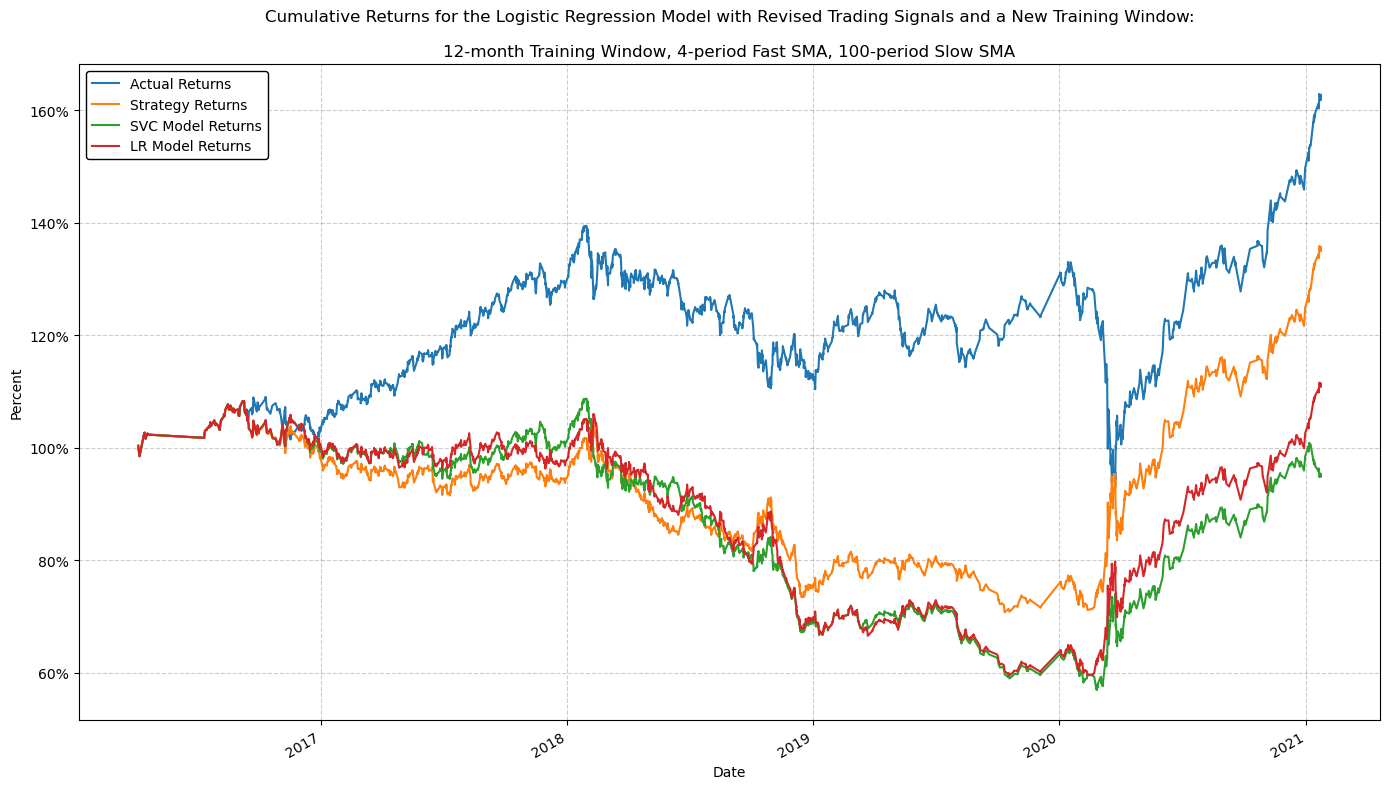

In [89]:
# Create the plot of trading algorithm performance
create_lr_plot(
    predictions_df_revisited_logistic_regression_2,
    sma_short_window,
    sma_long_window,
    training_data_offset_months,
    file_name
    , "Cumulative Returns for the Logistic Regression Model with Revised Trading Signals and a New Training Window:\n\n"
)

In [90]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_logistic_regression_2[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'New Training Window Revisited LR'}, inplace=True)

In [91]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['Baseline Returns Revisited LR'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited,Improved Trading Strategy,Baseline Returns LR,Baseline Returns Revisited LR,New Training Window Revisited LR
date,,,,,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237,NaN,-0.007237,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721,NaN
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841,NaN,0.003841,0.003841,NaN
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423,NaN,0.018423,0.018423,NaN
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674,NaN,-0.005674,-0.005674,NaN


In [92]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_logistic_regression_2[['LR Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'LR Model Returns':'New Training Window Revisited Model LR'}, inplace=True)

In [93]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['Baseline Returns Revisited Model LR'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model,Improved Trading Strategy Model,Baseline Returns Model LR,Baseline Returns Revisited Model LR,New Training Window Revisited Model LR
date,,,,,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237,NaN,0.007237,-0.007237,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721,NaN
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841,NaN,-0.003841,0.003841,NaN
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423,NaN,-0.018423,0.018423,NaN
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674,NaN,0.005674,-0.005674,NaN


## Case 11: Algorithm for the Improved Trading Strategy with New Trading Signals, New SMA Windows, and LR Classifiers

Confusion matrix for the trading algorithm:
3-month Training Window, 32-period Fast SMA, 160-period Slow SMA



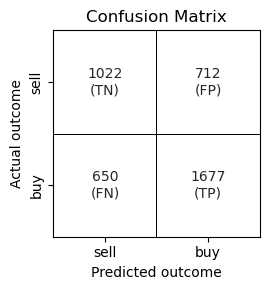


Classification report for the trading algorithm:
3-month Training Window, 32-period Fast SMA, 160-period Slow SMA


              precision    recall  f1-score   support

        -1.0       0.61      0.59      0.60      1734
         1.0       0.70      0.72      0.71      2327

    accuracy                           0.66      4061
   macro avg       0.66      0.66      0.66      4061
weighted avg       0.66      0.66      0.66      4061




In [94]:
# Set the initial variables
sma_short_window = 32
sma_long_window = 160
training_data_offset_months = 3
file_name = "11_improved_trading_strategy_logistic_regression"
svc_model_column = model_results_df['Improved Trading Strategy Model']

# Run the trading_algorithm function, using the variables above as the arguments
predictions_df_revisited_logistic_regression_3 = trading_algorithm_revisited_new_classifier(ohlcv_df, sma_short_window, sma_long_window, training_data_offset_months, file_name, svc_model_column)

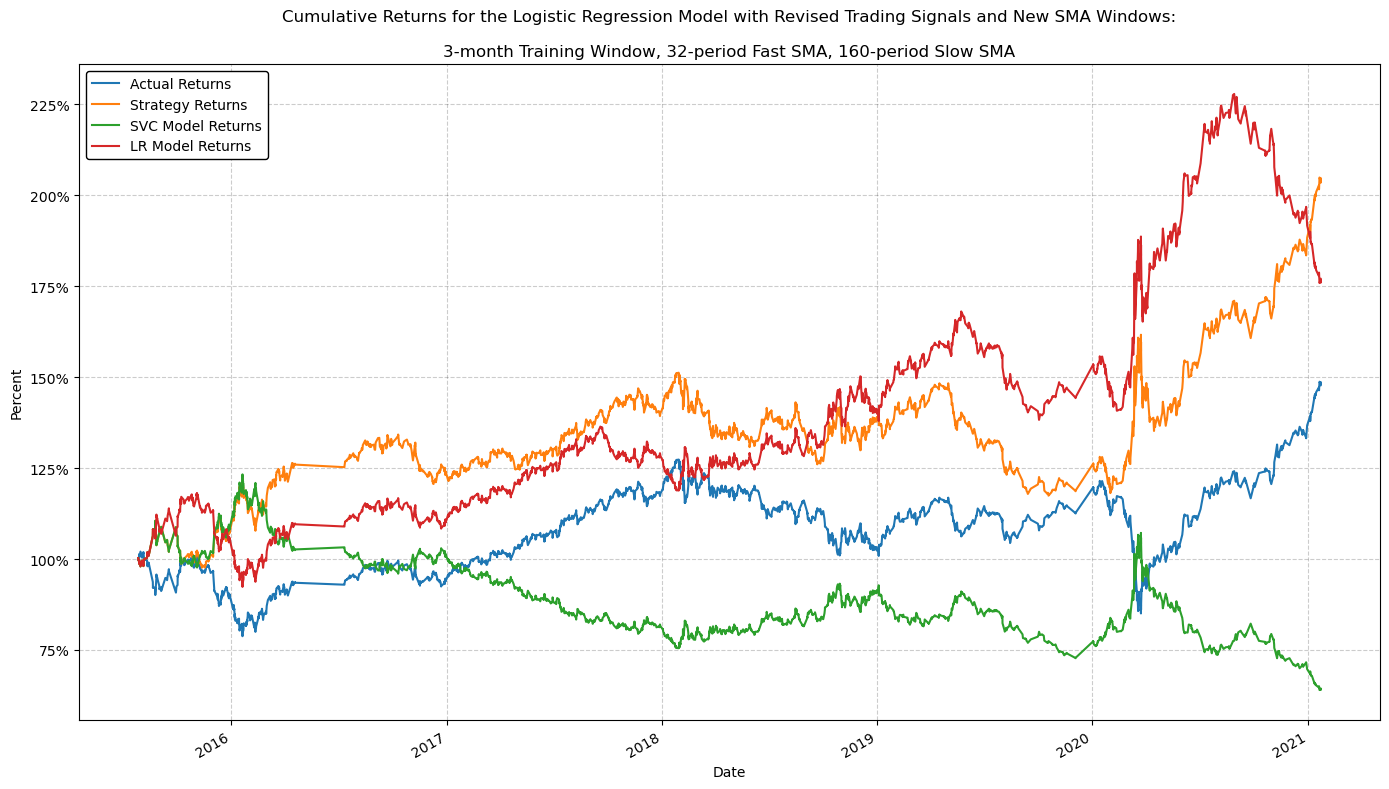

In [95]:
# Create the plot of trading algorithm performance
create_lr_plot(
    predictions_df_revisited_logistic_regression_3,
    sma_short_window,
    sma_long_window,
    training_data_offset_months,
    file_name
    , "Cumulative Returns for the Logistic Regression Model with Revised Trading Signals and New SMA Windows:\n\n"
)

In [96]:
# Merge (Left join) the new strategy returns to the results_df
strategy_results_df = strategy_results_df.merge(predictions_df_revisited_logistic_regression_3[['Strategy Returns']], on='date', how='left')

# Rename the Strategy Returns column
strategy_results_df.rename(columns={'Strategy Returns':'Improved Trading Strategy LR'}, inplace=True)

In [97]:
# Check that the results have been successfully added

strategy_results_df.head()
# strategy_results_df.loc[strategy_results_df['Baseline Returns LR'].isna() != True].head()

,Actual Returns,Baseline Returns,New Training Window,New SMA Windows,Baseline Returns Revisited,New Training Window Revisited,New SMA Windows Revisited,Improved Trading Strategy,Baseline Returns LR,Baseline Returns Revisited LR,New Training Window Revisited LR,Improved Trading Strategy LR
date,,,,,,,,,,,,
2015-07-06 10:45:00,0.007237,-0.007237,NaN,-0.007237,-0.007237,NaN,-0.007237,NaN,-0.007237,-0.007237,NaN,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721,NaN,NaN
2015-07-06 14:30:00,-0.003841,0.003841,NaN,0.003841,0.003841,NaN,0.003841,NaN,0.003841,0.003841,NaN,NaN
2015-07-07 11:30:00,-0.018423,0.018423,NaN,0.018423,0.018423,NaN,0.018423,NaN,0.018423,0.018423,NaN,NaN
2015-07-07 13:45:00,0.005674,-0.005674,NaN,-0.005674,-0.005674,NaN,-0.005674,NaN,-0.005674,-0.005674,NaN,NaN


In [98]:
# Merge (Left join) the new  model returns to the results_df
model_results_df = model_results_df.merge(predictions_df_revisited_logistic_regression_2[['LR Model Returns']], on='date', how='left')

# Rename the Model Returns column
model_results_df.rename(columns={'LR Model Returns':'Improved Trading Strategy Model LR'}, inplace=True)

In [99]:
# Check that the results have been successfully added

model_results_df.head()
# model_results_df.loc[model_results_df['Baseline Returns Model LR'].isna() != True].head()

,Actual Returns,Baseline Model Returns,New Training Window Model,New SMA Windows Model,Baseline Returns Revisited Model,New Training Window Revisited Model,New SMA Windows Revisited Model,Improved Trading Strategy Model,Baseline Returns Model LR,Baseline Returns Revisited Model LR,New Training Window Revisited Model LR,Improved Trading Strategy Model LR
date,,,,,,,,,,,,
2015-07-06 10:45:00,0.007237,0.007237,NaN,0.007237,-0.007237,NaN,-0.007237,NaN,0.007237,-0.007237,NaN,NaN
2015-07-06 14:15:00,-0.009721,-0.009721,NaN,-0.009721,0.009721,NaN,0.009721,NaN,-0.009721,0.009721,NaN,NaN
2015-07-06 14:30:00,-0.003841,-0.003841,NaN,-0.003841,0.003841,NaN,0.003841,NaN,-0.003841,0.003841,NaN,NaN
2015-07-07 11:30:00,-0.018423,-0.018423,NaN,-0.018423,0.018423,NaN,0.018423,NaN,-0.018423,0.018423,NaN,NaN
2015-07-07 13:45:00,0.005674,0.005674,NaN,0.005674,-0.005674,NaN,-0.005674,NaN,0.005674,-0.005674,NaN,NaN


## Summary Plots

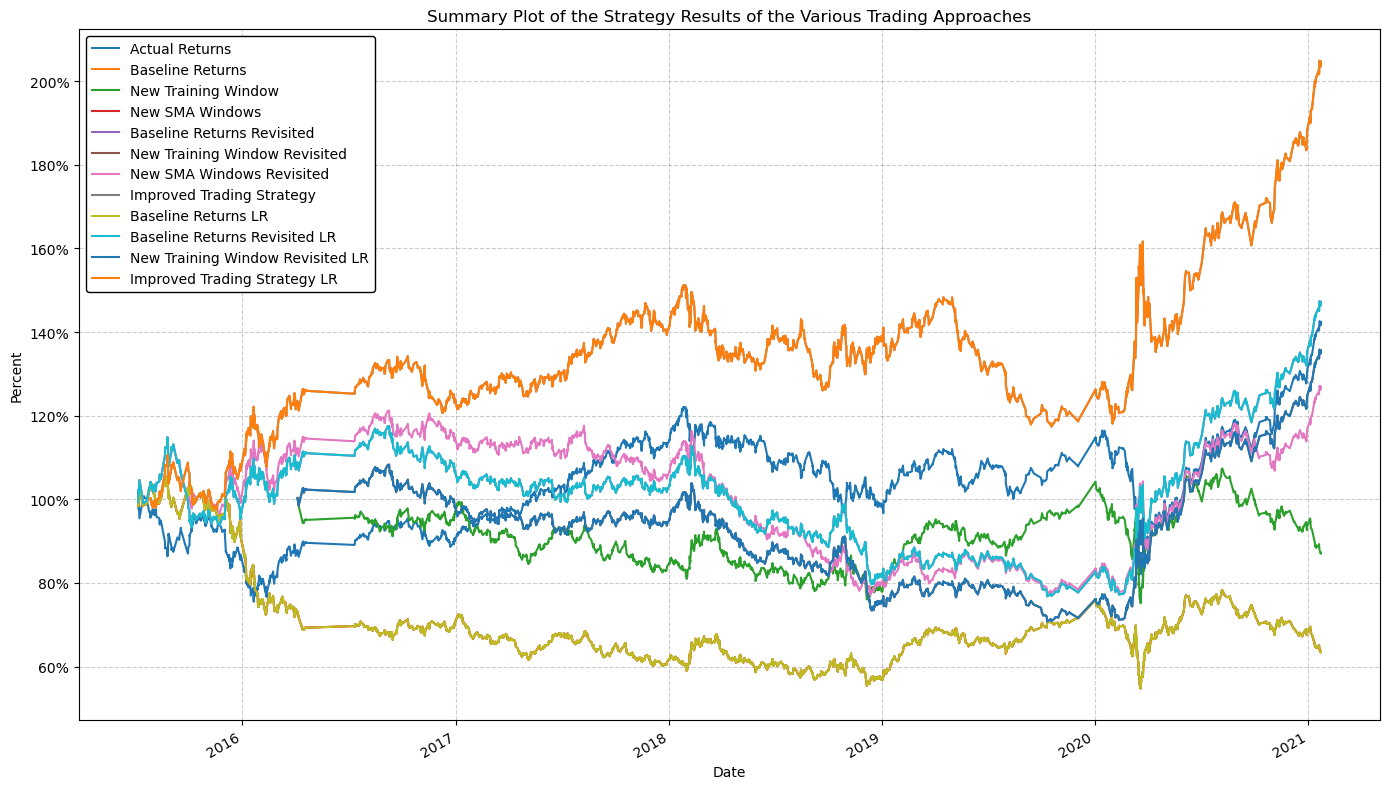

In [100]:
# Plot the actual returns versus the strategy returns

# Initialize the figure, including the size
fig = (1 + strategy_results_df).cumprod().plot(
    figsize=(14,8)
)

# Add a title to the plot
plt.title(f"Summary Plot of the Strategy Results of the Various Trading Approaches")

# Create a variable that refers to the axis
ax = plt.gca()

# Set the x- and y-axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Percent')

# Format the y-axis as a percentage
# The kwarg in PercentFormatter is the float value used as the divisor to create the percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Rescale the axis boundaries
# ax.axis([
#     min(signals_df.index) - (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Minimum value on the x-axis
#     max(signals_df.index) + (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Maximum value on the x-axis
#     0,
#     1.4
# ])

# Add a horizontal line to improve readability
# ax.axhline(y=1, color='k', linestyle="--", alpha=0.2)

# Create a light grid to improve readability
ax.grid(which='major', color='k', linestyle='--', alpha=0.2)

# Set the legend paramters
plt.legend(
    framealpha=1.0, # Make the legend opaque
    edgecolor='k' # Set the edge color to black
)

# Reduce the whitespace around the plot
plt.tight_layout()

# Save the figure as a PNG
png_file_name = '20_Trading_Strategy_Summary'
relative_file_path = "./Plots/" + str(png_file_name) + ".png"
plt.savefig(Path(relative_file_path))

plt.show()

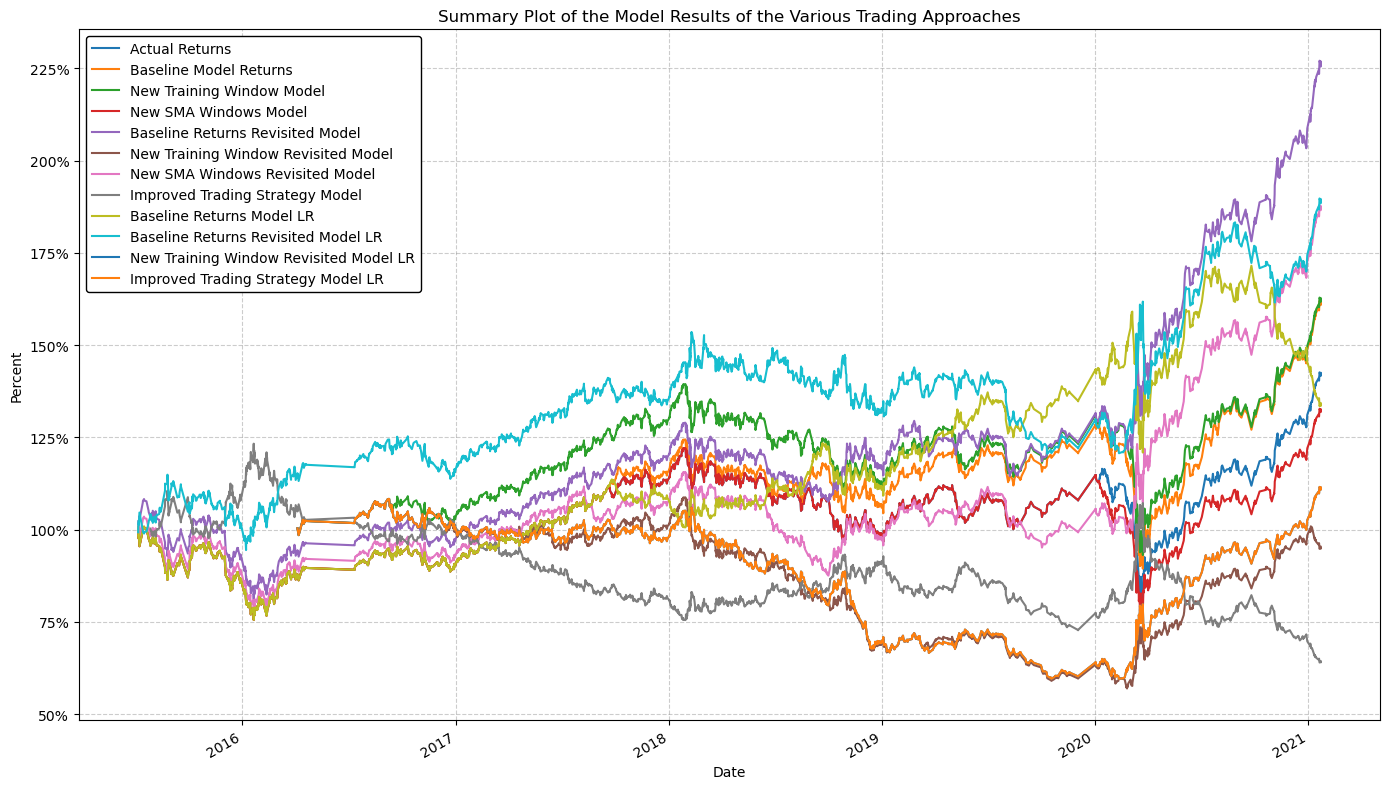

In [101]:
# Plot the actual returns versus the strategy returns

# Initialize the figure, including the size
fig = (1 + model_results_df).cumprod().plot(
    figsize=(14,8)
)

# Add a title to the plot
plt.title(f"Summary Plot of the Model Results of the Various Trading Approaches")

# Create a variable that refers to the axis
ax = plt.gca()

# Set the x- and y-axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Percent')

# Format the y-axis as a percentage
# The kwarg in PercentFormatter is the float value used as the divisor to create the percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Rescale the axis boundaries
# ax.axis([
#     min(signals_df.index) - (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Minimum value on the x-axis
#     max(signals_df.index) + (0.025 * ( max(signals_df.index) - min(signals_df.index) ) ), # Maximum value on the x-axis
#     0,
#     1.4
# ])

# Add a horizontal line to improve readability
# ax.axhline(y=1, color='k', linestyle="--", alpha=0.2)

# Create a light grid to improve readability
ax.grid(which='major', color='k', linestyle='--', alpha=0.2)

# Set the legend paramters
plt.legend(
    framealpha=1.0, # Make the legend opaque
    edgecolor='k' # Set the edge color to black
)

# Reduce the whitespace around the plot
plt.tight_layout()

# Save the figure as a PNG
png_file_name = '21_Model_Retults_Summary'
relative_file_path = "./Plots/" + str(png_file_name) + ".png"
plt.savefig(Path(relative_file_path))

plt.show()